In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable

from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from scipy import interpolate

In [4]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

In [5]:
def get_K_r_rp_full(m):
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

    R_ls = []
    R_drs = []


    for X in Xs:
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        R_ls.append(R_l)
        R_drs.append(R_dr)


    R0 = np.array(R_ls)
    RD = 2*np.array(R_drs)
    R = R0 -RD
    KK = 1/(R/Xs)
    K_min_arg = np.argmin(KK)

    K_d = KK[:K_min_arg]
    K_u = KK[K_min_arg:]
    r_d = Xs[:K_min_arg]/K_d
    r_u = Xs[K_min_arg:]/K_u
    R_0d = R0[:K_min_arg]
    R_0u = R0[K_min_arg:]
    R_dd = -RD[:K_min_arg]
    R_du = -RD[K_min_arg:]

    R_u = R_0u + R_du
    R_d = R_0d + R_dd
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]
    Xsd = Xs[:K_min_arg]

    a = 1/np.sqrt(Xsu*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPS = b*Xsu


    a = 1/np.sqrt(Xsd*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPSd = b*Xsd


    RP1_d = []
    RP1_u = []
    RPl_d = []
    RPl_u = []
    K1p = []

    for K, r, r0, OP in zip(K_u, R_u, R_0u, OPS):
        # 1. 적당한 간격으로 샘플
        rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
        diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


        # 2. sign change 구간 찾기 (교점 후보)
        sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

        try:
            # 첫 번째 교점
            i1 = sign_change[0]
            if len(sign_change) == 1:
                rp_left = 0
                RP1_d.append(0)
                RPl_d.append(0)
                
            else:
                rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
                RP1_d.append(rp_left)
                RPl_d.append(RP_l(rp_left, K, r0, OP, m))


                
            # 두 번째 교점
            i2 = sign_change[-1]
            rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

            RP1_u.append(rp_right)
            RPl_u.append(RP_l(rp_right, K, r0, OP, m))
            K1p.append(K)
        except:
            K1p.append(K)
            RP1_d.append(np.nan)
            RP1_u.append(np.nan)
            RPl_d.append(np.nan)
            RPl_u.append(np.nan)


    K1p = np.array(K1p)
    RP1_u = np.array(RP1_u)
    RPl_u = np.array(RPl_u)
    RP1_d = np.array(RP1_d)
    RPl_d = np.array(RPl_d)


    arg, = np.where(RP1_u<1e-13)
    K1p[arg] = np.nan
    RPl_u[arg] = np.nan
    RP1_u[arg] = np.nan
    RPl_d[arg] = np.nan
    RP1_d[arg] = np.nan
    return R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start


In [7]:
def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=200)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan


In [69]:
m = 6
R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start = get_K_r_rp_full(m)

In [70]:
def get_omega_p(K,r,m):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    return omega_p

def get_delta_P(K,R,r0,rp,m):
    OP = get_omega_p(K,R,m)
    delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
    return delta_P


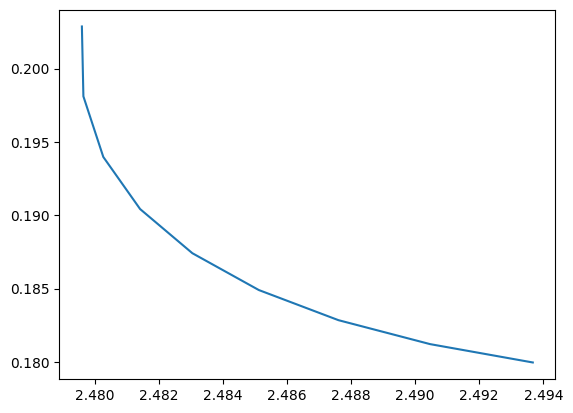

In [71]:
plt.plot(np.where(2*RP1_u>R_0u,K1p,np.nan),2*RP1_u)

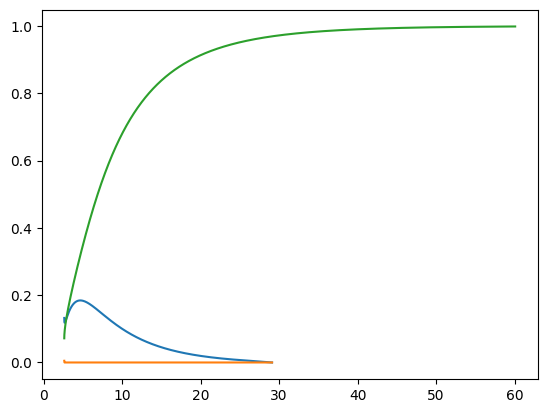

In [58]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)
plt.plot(K1p,R_u)
# plt.plot(K1p,R_d)

In [59]:
m = 10
omega_p = get_omega_p(K1p,R_u,m)
delta_P = get_delta_P(K1p,R_u,R_0u,RP1_u,m)
omega_pp = get_omega_p(K1p,RP1_u,m)

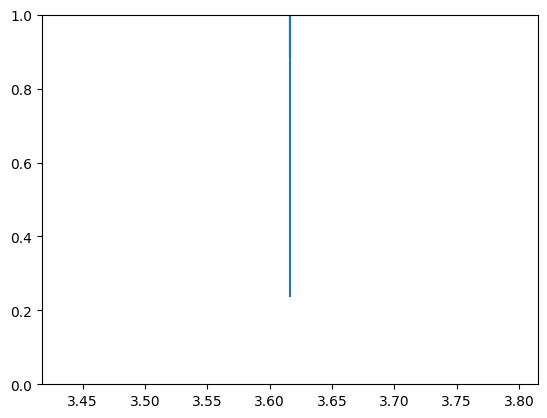

In [60]:
idx = 100
plt.axvline(K1p[idx],delta_P[idx])
plt.axvline(K1p[idx],delta_P[idx]+omega_p[idx]+omega_pp[idx])
plt.axvline(K1p[idx],delta_P[idx]+omega_p[idx]+omega_pp[idx])



(0.0, 3.2685146031747343)

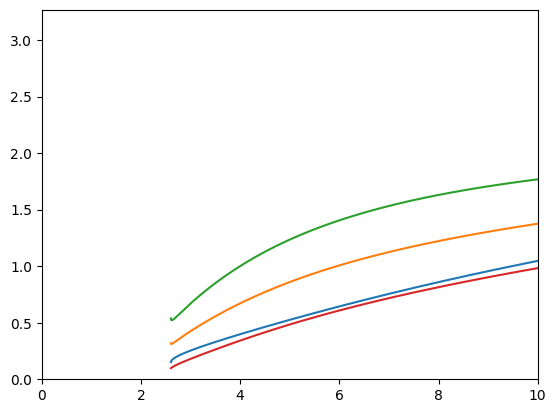

In [61]:
plt.plot(K1p,omega_p)
plt.plot(K1p,delta_P+omega_p)
plt.plot(K1p,delta_P+omega_p+omega_pp)
plt.plot(K1p,delta_P+omega_p-omega_pp)
plt.xlim(0,10)
plt.ylim(0)

In [62]:
K_ = np.linspace(0,10,1000)

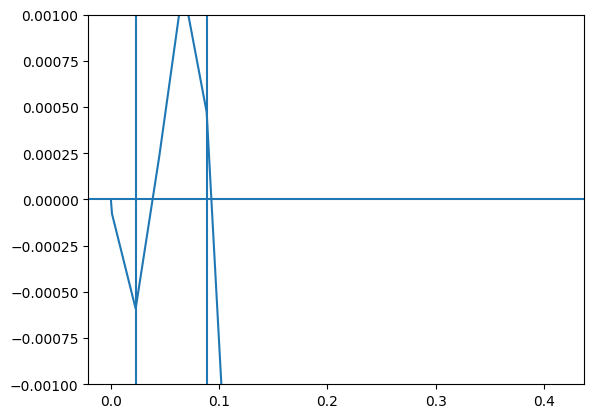

In [14]:
m = 6
# rs = np.linspace(0,1,10000)[1:]

Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    if m !=0:
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    else:
        R_dr = 0
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd



F_Ru = interpolate.interp1d(K_u,R_u,kind='linear',bounds_error=False,fill_value=np.nan)
F_R0u = interpolate.interp1d(K_u,R_0u,kind='linear',bounds_error=False,fill_value=np.nan)
F_OPS = interpolate.interp1d(K_u,OPS,kind='linear',bounds_error=False,fill_value=np.nan)

F_Rd = interpolate.interp1d(K_d,R_d,kind='linear',bounds_error=False,fill_value=np.nan)
F_R0d = interpolate.interp1d(K_d,R_0d,kind='linear',bounds_error=False,fill_value=np.nan)



Ku_ = K_[K_>=K_start] 



RP1_d = []
RP1_u = []
RPl_d = []
RPl_u = []
K1p = []
num = 0
diff_lists = []

for K in K_[K_<K_start]:
    RP1_d.append(np.nan)
    RP1_u.append(np.nan)
    RPl_d.append(np.nan)
    RPl_u.append(np.nan)
    K1p.append(K)
for K, r, r0, OP in zip(Ku_, F_Ru(Ku_), F_R0u(Ku_), F_OPS(Ku_)):
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-12, -3, 20), np.linspace(0.001, (1 - r0) / 2, 20)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
    diff_lists.append(len(sign_change))
    try:
        # 첫 번째 교점
            
        i1 = sign_change[0]
        # sol = root_scalar(RP_diff, bracket=(rps[i1],rps[i1+1]), args=(K,r0,OP,m), method='toms748', xtol=1e-6, rtol=1e-6, maxiter=200)
        # r_star = sol.root if sol.converged else np.nan
        if len(sign_change) == 1:
            rp_left = 0
            RP1_d.append(0)
            RPl_d.append(0)
            
        else:
            rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
            RP1_d.append(rp_left)
            RPl_d.append(RP_l(rp_left, K, r0, OP, m))
            
        # rp_left = r_star

        # 두 번째 교점
        i2 = sign_change[-1]
        # sol = root_scalar(RP_diff, bracket=(rps[i2-1],rps[i2+1]), args=(K,r0,OP,m), method='toms748', xtol=1e-6, rtol=1e-6, maxiter=200)
        # r_star = sol.root if sol.converged else np.nan
        
        rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))
        # rp_right = r_star

        RP1_u.append(rp_right)

        # RP값도 같이 저장
        
        RPl_u.append(RP_l(rp_right, K, r0, OP, m))
        K1p.append(K)
    except:
        K1p.append(K)
        RP1_d.append(np.nan)
        RP1_u.append(np.nan)
        RPl_d.append(np.nan)
        RPl_u.append(np.nan)
    if num == 0:
        plt.plot(rps,diffs)
        for i in sign_change:
            plt.axvline(rps[i])
        plt.axhline(0)
        plt.ylim(-1e-3,1e-3)
        num += 1

K1p = np.array(K1p)
RP1_u = np.array(RP1_u)
RPl_u = np.array(RPl_u)
RP1_d = np.array(RP1_d)
RPl_d = np.array(RPl_d)


arg, = np.where(RP1_u<1e-4)
K1p[arg] = np.nan
RPl_u[arg] = np.nan
RP1_u[arg] = np.nan
RPl_d[arg] = np.nan
RP1_d[arg] = np.nan



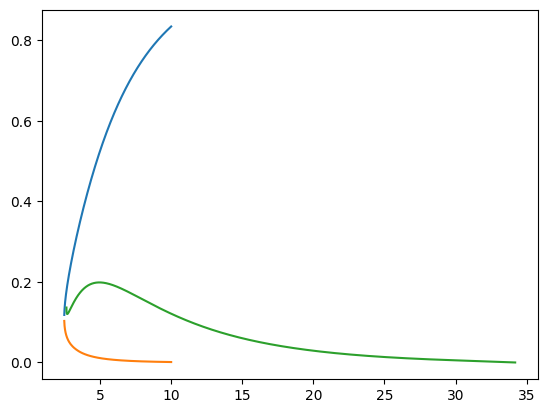

In [55]:
plt.plot(K_,F_Ru(K_))
plt.plot(K_,F_Rd(K_))

plt.plot(K1p,RP1_u)

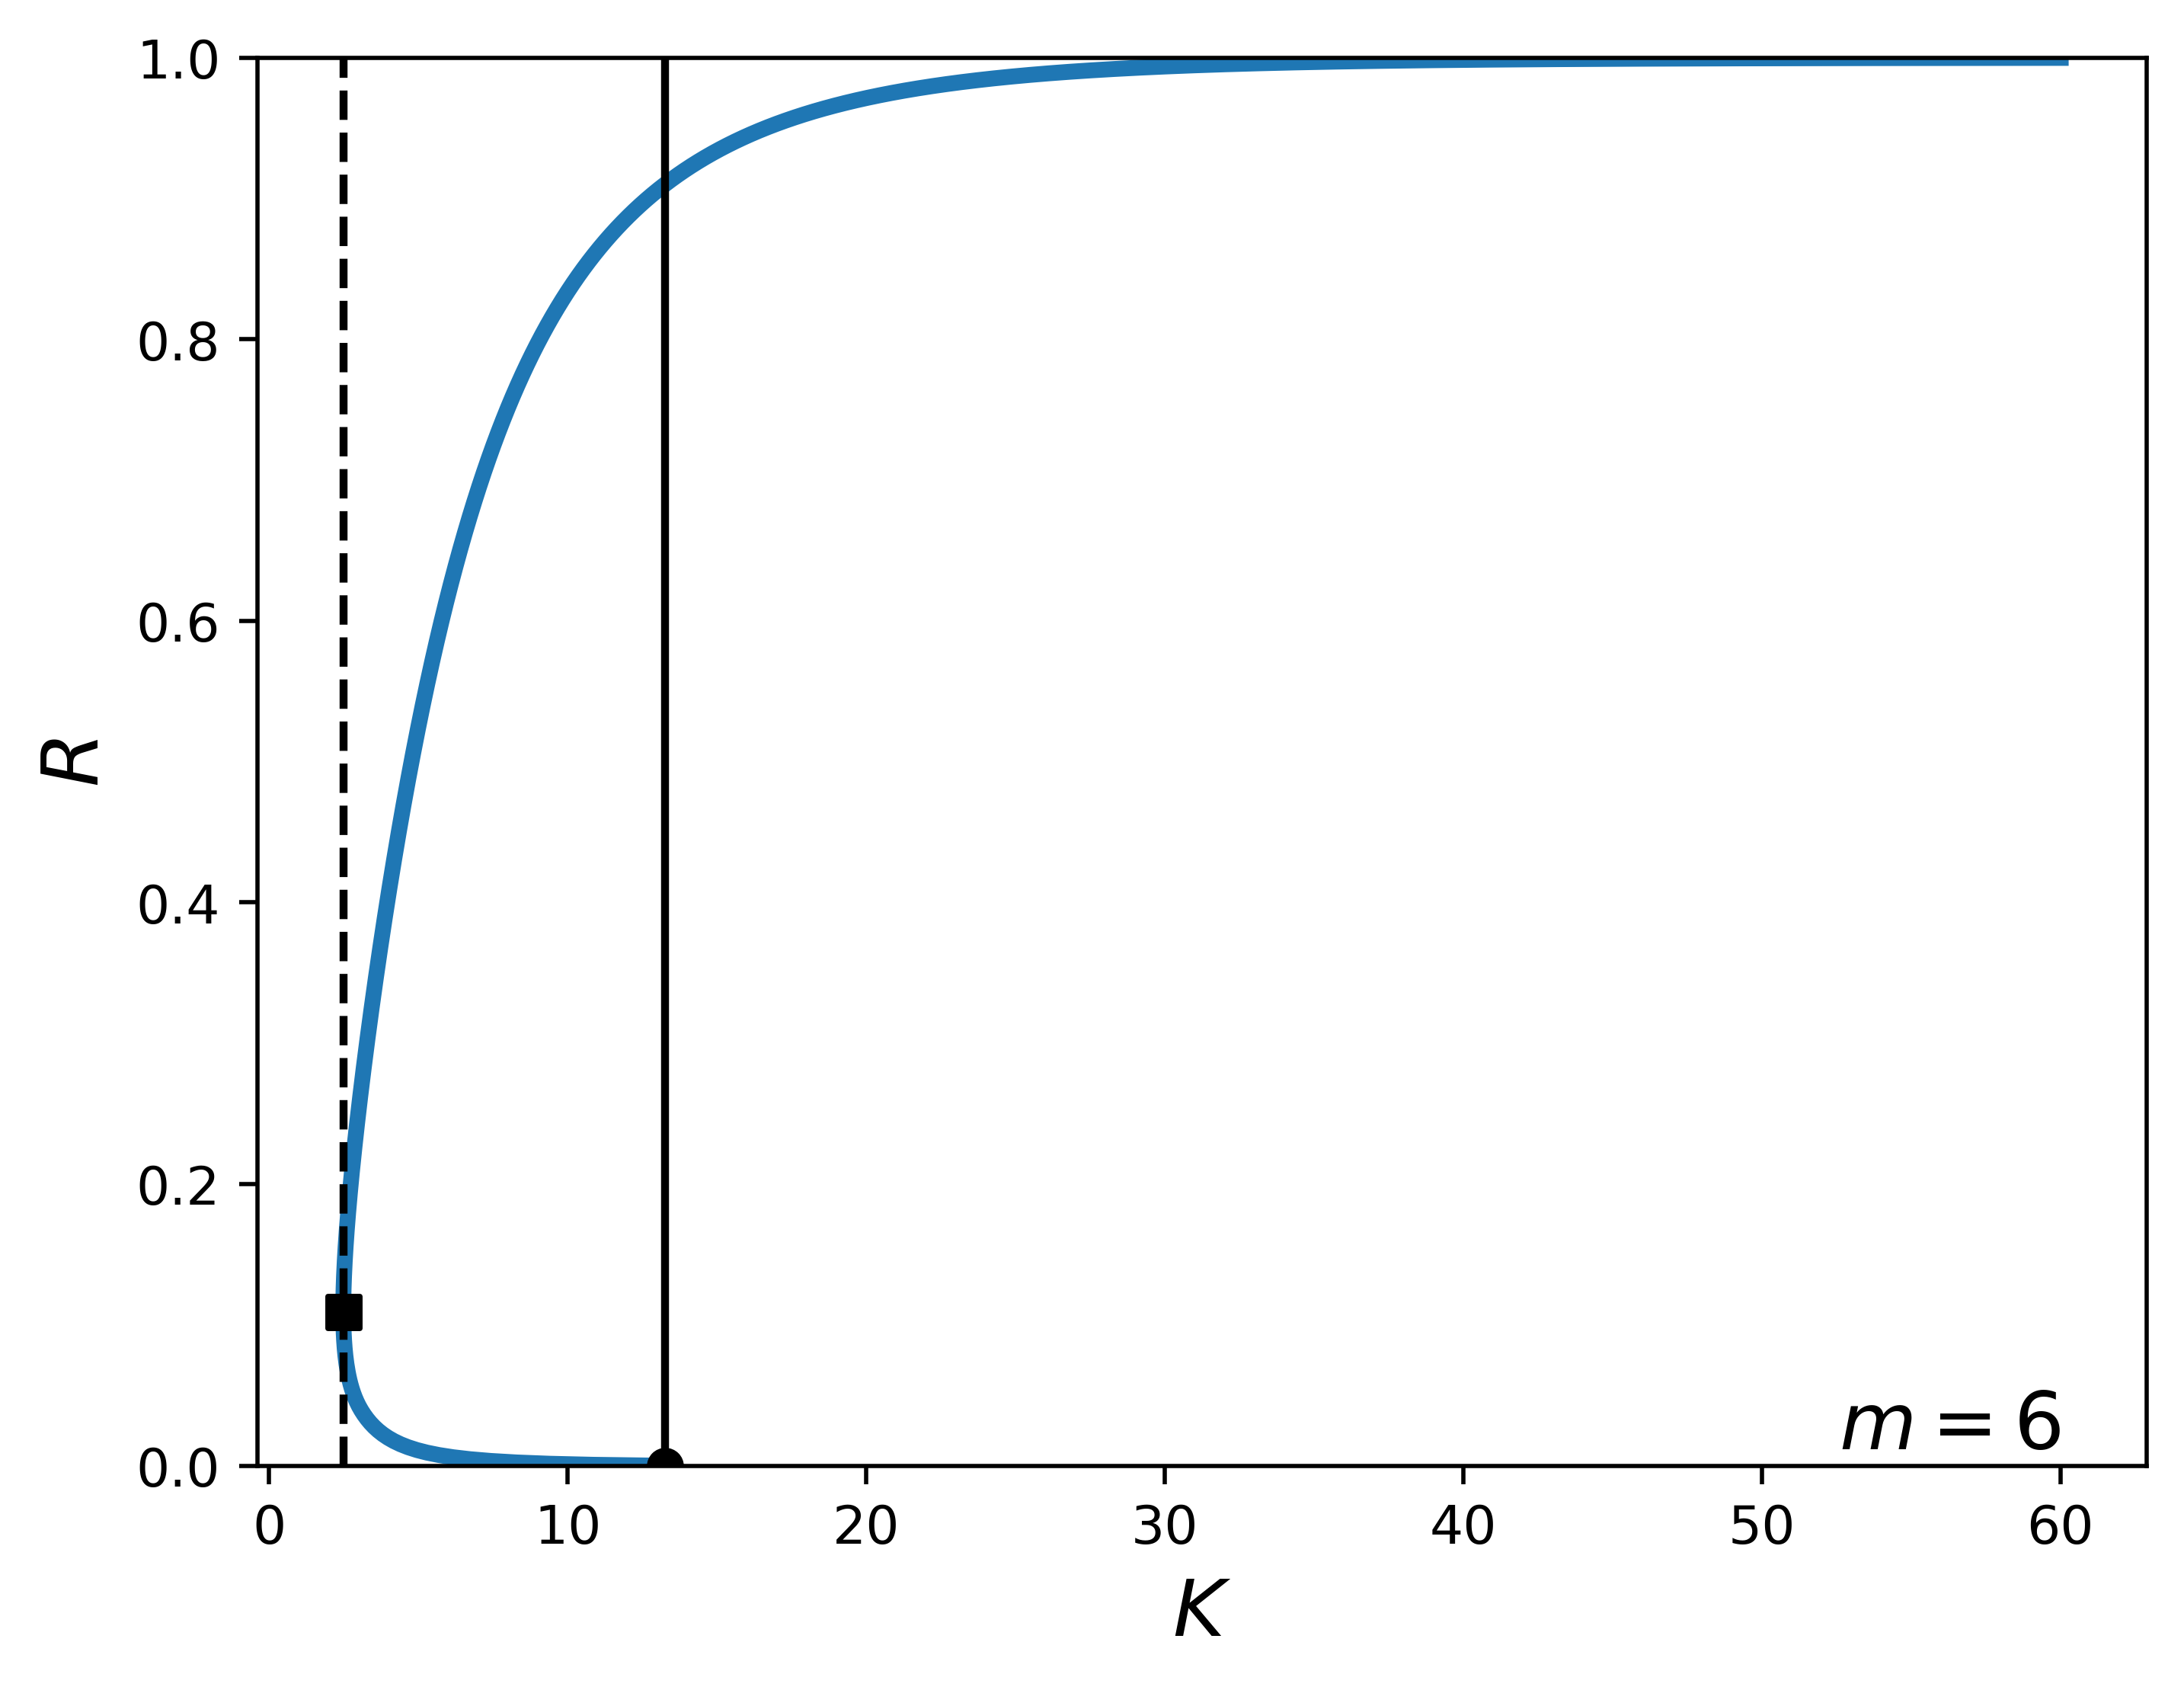

In [11]:
plt.figure(dpi=500)
plt.plot(KK,R,lw=3)
plt.scatter(KK[0],R[0],color='k',zorder=3)
plt.scatter(K_u[0],R_u[0],color='k',marker='s',zorder=3)
plt.axvline(KK[0],color='k',linestyle='-',zorder=2)
plt.axvline(K_u[0],color='k',linestyle='--',zorder=2)
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$R$',fontsize=15)
plt.text(KK[-1],R[0],rf'$m={m}$',fontsize=15,ha='right',va='bottom')
plt.ylim(0,1)
plt.show()


In [ ]:
plt.plot()